In [1]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

#Hyperparameter 설정
BATCH_SIZE = 16
TRANSFORM = transforms.Compose([transforms.ToTensor(),])
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = datasets.FashionMNIST(root='.', train=True,
                                  transform=TRANSFORM,
                                  target_transform=None,
                                  download=True)

test_data = datasets.FashionMNIST(root='.', train=False,
                                  transform=TRANSFORM,
                                  target_transform=None,
                                  download=True)

train_loader = DataLoader(dataset=train_data,
                         batch_size = BATCH_SIZE,
                         shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size = BATCH_SIZE,
                         shuffle=True)

In [3]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([16, 1, 28, 28])
Image label dimensions: torch.Size([16])


In [4]:
# Hyperparameters
random_seed = 1
learning_rate = 1e-2
num_epochs = 100
batch_size = 64
dropout_prob = 0.5

# Architecture
num_features = 784
num_hidden_1 = 128
num_hidden_2 = 64
num_classes = 10

In [5]:
##########################
### MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas
    
torch.manual_seed(random_seed)

model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
CLASS_CLOTHING = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

In [7]:
def compute_accuracy(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

In [8]:
from tqdm import tqdm
history = {'val_acc': [], 'train_acc':[]}
start_time = time.time()

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
    ### LOGGING
    history['train_acc'].append(compute_accuracy(model, train_loader))
    history["val_acc"].append(compute_accuracy(model, test_loader))
        
    if epoch % 10 == 0:
        print ('Epoch: %03d/%03d | Cost: %.4f' 
                %(epoch+1, num_epochs, cost))
        
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                  epoch+1, num_epochs, 
                  compute_accuracy(model, train_loader)))
     
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch: 001/100 | Cost: 0.3173
Epoch: 001/100 training accuracy: 82.60%
Time elapsed: 2.38 min


 10%|███████▉                                                                       | 10/100 [15:54<2:19:30, 93.01s/it]

Epoch: 011/100 | Cost: 0.1979
Epoch: 011/100 training accuracy: 88.95%
Time elapsed: 17.91 min


 20%|███████████████▊                                                               | 20/100 [31:11<1:59:11, 89.40s/it]

Epoch: 021/100 | Cost: 0.5052
Epoch: 021/100 training accuracy: 91.58%
Time elapsed: 33.20 min


 30%|███████████████████████▋                                                       | 30/100 [46:32<1:43:45, 88.94s/it]

Epoch: 031/100 | Cost: 0.2473
Epoch: 031/100 training accuracy: 93.35%
Time elapsed: 48.54 min


 40%|██████████████████████████████▊                                              | 40/100 [1:02:02<1:30:28, 90.48s/it]

Epoch: 041/100 | Cost: 0.2175
Epoch: 041/100 training accuracy: 94.41%
Time elapsed: 64.10 min


 50%|██████████████████████████████████████▌                                      | 50/100 [1:17:21<1:13:46, 88.53s/it]

Epoch: 051/100 | Cost: 0.2285
Epoch: 051/100 training accuracy: 95.57%
Time elapsed: 79.35 min


 60%|█████████████████████████████████████████████▌                              | 60/100 [1:37:18<1:36:31, 144.79s/it]

Epoch: 061/100 | Cost: 0.0565
Epoch: 061/100 training accuracy: 96.06%
Time elapsed: 100.67 min


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [2:02:07<1:11:52, 143.73s/it]

Epoch: 071/100 | Cost: 0.0196
Epoch: 071/100 training accuracy: 95.59%
Time elapsed: 125.39 min


 80%|██████████████████████████████████████████████████████████████▍               | 80/100 [2:26:37<47:15, 141.78s/it]

Epoch: 081/100 | Cost: 0.1498
Epoch: 081/100 training accuracy: 96.75%
Time elapsed: 149.81 min


 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [2:51:09<24:05, 144.51s/it]

Epoch: 091/100 | Cost: 0.0521
Epoch: 091/100 training accuracy: 97.54%
Time elapsed: 174.29 min


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:14:33<00:00, 136.25s/it]


Total Training Time: 194.56 min


In [9]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 88.21%


In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(num_epochs), history['val_acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
##########################
### BATCH NORM MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = torch.nn.BatchNorm1d(num_hidden_1)
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = torch.nn.BatchNorm1d(num_hidden_2)
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        # note that batchnorm is in the classic
        # sense placed before the activation
        out = self.linear_1_bn(out)
        out = F.relu(out)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
def compute_accuracy(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
    ### LOGGING
    history['train_acc'].append(compute_accuracy(model, train_loader))
    history["val_acc"].append(compute_accuracy(model, test_loader))
        
    if epoch % 10 == 0:
        print ('Epoch: %03d/%03d | Cost: %.4f' 
                %(epoch+1, num_epochs, cost))
        
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                  epoch+1, num_epochs, 
                  compute_accuracy(model, train_loader)))
     
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Cost: 0.5474
Epoch: 001/100 training accuracy: 83.23%
Time elapsed: 3.51 min
Epoch: 011/100 | Cost: 0.2250
Epoch: 011/100 training accuracy: 90.24%
Time elapsed: 30.99 min
Epoch: 021/100 | Cost: 0.4264
Epoch: 021/100 training accuracy: 91.83%
Time elapsed: 57.91 min
Epoch: 031/100 | Cost: 0.4254
Epoch: 031/100 training accuracy: 93.04%
Time elapsed: 76.26 min
Epoch: 041/100 | Cost: 0.2736
Epoch: 041/100 training accuracy: 94.31%
Time elapsed: 94.05 min
Epoch: 051/100 | Cost: 0.1814
Epoch: 051/100 training accuracy: 94.88%
Time elapsed: 111.94 min
Epoch: 061/100 | Cost: 0.1172
Epoch: 061/100 training accuracy: 95.82%
Time elapsed: 129.98 min
Epoch: 071/100 | Cost: 0.0979
Epoch: 071/100 training accuracy: 96.50%
Time elapsed: 147.88 min
Epoch: 081/100 | Cost: 0.7027
Epoch: 081/100 training accuracy: 96.71%
Time elapsed: 165.72 min
Epoch: 091/100 | Cost: 0.1696
Epoch: 091/100 training accuracy: 97.41%
Time elapsed: 183.40 min
Total Training Time: 198.97 min


In [13]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 89.02%


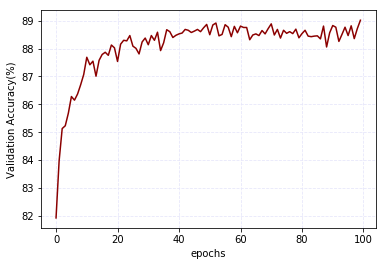

In [22]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(num_epochs), history['val_acc'][100:200], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [15]:
##########################
### DROPOUT MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
def compute_accuracy(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
    
    ### LOGGING
    history['train_acc'].append(compute_accuracy(model, train_loader))
    history["val_acc"].append(compute_accuracy(model, test_loader))
        
    if epoch % 10 == 0:
        print ('Epoch: %03d/%03d | Cost: %.4f' 
                %(epoch+1, num_epochs, cost))
        
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                  epoch+1, num_epochs, 
                  compute_accuracy(model, train_loader)))
     
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Cost: 0.6317
Epoch: 001/100 training accuracy: 76.55%
Time elapsed: 2.18 min
Epoch: 011/100 | Cost: 0.3060
Epoch: 011/100 training accuracy: 86.29%
Time elapsed: 18.38 min
Epoch: 021/100 | Cost: 0.2154
Epoch: 021/100 training accuracy: 87.86%
Time elapsed: 34.59 min
Epoch: 031/100 | Cost: 0.4668
Epoch: 031/100 training accuracy: 88.82%
Time elapsed: 50.93 min
Epoch: 041/100 | Cost: 0.0699
Epoch: 041/100 training accuracy: 89.73%
Time elapsed: 67.28 min
Epoch: 051/100 | Cost: 0.3809
Epoch: 051/100 training accuracy: 89.76%
Time elapsed: 83.35 min
Epoch: 061/100 | Cost: 0.1173
Epoch: 061/100 training accuracy: 90.61%
Time elapsed: 99.43 min
Epoch: 071/100 | Cost: 0.4872
Epoch: 071/100 training accuracy: 90.82%
Time elapsed: 115.67 min
Epoch: 081/100 | Cost: 1.2321
Epoch: 081/100 training accuracy: 91.06%
Time elapsed: 131.89 min
Epoch: 091/100 | Cost: 0.3843
Epoch: 091/100 training accuracy: 91.43%
Time elapsed: 148.74 min
Total Training Time: 162.86 min


In [17]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 87.85%


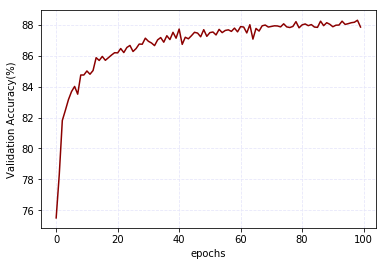

In [23]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(num_epochs), history['val_acc'][200:300], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [ ]:
"""
- 일반 모델에 비해 Batch Normalization을 진행한 모델에서 accuracy가 높았다.
- Dropout을 진행한 모델에서는 오히려 accuracy가 떨어졌다.

이유
1. 마지막 layer 바로 전 layer에 dropout을 적용하는 것이 일반적으로 성능을 더 떨어뜨린다.
2. dataset에 비해 network가 작은 경우 정규화가 필요하지 않다.
3. 수렴할 때까지 train을 진행하지 않은 경우 dropout은 성능을 더 떨어뜨린다.
출처: https://stats.stackexchange.com/questions/299292/dropout-makes-performance-worse
"""